# AI for Earth System Science Hackathon 2020
# GOES Challenge
David John Gagne, Gunther Wallach, Charlie Becker, Bill Petzke

## Introduction
![GOES-R satellite image from Wikipedia](goes_images/GOES-R_SPACECRAFT.jpg)

Lightning kills roughly 30 people per year in the United States (https://www.weather.gov/safety/lightning-victims) and can have large economic impacts by disrupting outdoor work and events and by sparking fires. Improved short term prediction of lightning onset can help protect life and property by ensuring that people can get to safety with sufficient lead time. The economic impacts of lightning protection practices can also be reduced by improving the prediction of when lightning is expected to end. 

Recently deployed observational systems combined with advances in machine learning have the potential to improve the short-term prediction of lightning by associating broader scale weather patterns with the future occurrence of lightning in that area. The Geostationary Operational Environmental Satellite 16 (GOES-16) is a weather satellite that orbits the Earth at a fixed point situated along the same longitude as the Eastern United States and can provide a hemispheric, multispectral view of cloud patterns at high space and time resolution through its Advanced Baseline Imager (ABI) camera. The satellite also holds the Geostationary Lightning Mapper (GLM) instrument that records lightning flashes across the hemispheric view of the satellite. By combining the data collected by these two instruments, we can develop new machine learning solutions to the challenge of short range lightning prediction.  

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm


In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 h5netcdf tqdm tensorflow scikit-learn dask s3fs goes16ci seaborn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import random
import xarray as xr
import tensorflow as tf
import matplotlib.pyplot as plt
from dask.distributed import Client, LocalCluster, progress
from goes16ci.models import StandardConvNet, ResNet, MinMaxScaler2D
import s3fs
from glob import glob
from sklearn import metrics
%matplotlib inline

# Set random seed
seed = 3985
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## Data

### Data Generation


There are several GOES-16 data products available. We are primarily interested in the water vapor bands from the Advanced Baseline Imager (ABI) and lightning counts from the Geostationary Lightning Mapper (GLM). The ABI camera’s spatial resolution is 2 km with a temporal resolution of 5 minutes. We chose to select/crop 32 x 32 sized image patches (for each band) across our domain (CONUS Midwest) at an upsampled rate of every 20 minutes from 2019-03-02 through 2019-10-01. We used these same spatio-temporal patches to aggregate all lightning flash counts within that patch but lagged by one hour. Total aggregated data was output at a daily interval.  

### Useful Links

[Overall GOES-16 Band Reference Guide](https://www.weather.gov/media/crp/GOES_16_Guides_FINALBIS.pdf)

[GOES-16 Band 08 Info (Upper-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band08.pdf)

[GOES-16 Band 09 Info (Mid-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band09.pdf)

[GOES-16 Band 10 Info (Low-level Water Vapor)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band10.pdf)

[GOES-16 Band 14 Info (Longwave Window)](http://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_Band14.pdf)

[GOES-16 Geostationary Lightning Mapper (GLM)](https://www.goes-r.gov/spacesegment/glm.html)


### Time span of the dataset

|  | Date/Time | 
| ------------- | :---- |
| Start | 2019-03-02 00:20:00 | 
| End | 2019-10-02 00:00:00 |
| Timestep | 00:20:00 | 
| NOTE: some days are missing (intentionally skipped) to isolate convective cycles





### Geographic Coverage of Dataset (Mostly Midwest CONUS)

|  | Latitude | Longitude |
| ------------- | :----:|:- |
| Min | 29.09 | -97.77 |
| Max | 48.97 | -82.53 |




### Dimensions

| Dimension Name | Description | Size |
| ------------- | :----:|:----------- |
| Band     | ABI Band Number  | 4 (Bands 8,9,10,14) |
| Patch      | spatio-temporal patch | ~3600 per day |
| X      | X-plane | 32 |
| Y      | Y-plane | 32 |

### Potential Input Variables

| Variable Name | Units | Description | 
| ------------- | :----:|:----------- | 
| abi (Band 08)   | K     | Upper-level Water Vapor | 
| abi (Band 09)   | K     | Mid-level Water Vapor   |
| abi (Band 10)   | K     | Lower-level Water Vapor |
| abi (Band 14)   | K     | Longwave Window         |

### Output Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| flash_counts    | -     | Lightning strike count |


### Metadata Variables

| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| Time     | YYYY-MM-DDTHH:MM:SS  | The Date   |
| Lat      | Degrees     | Latitude   |
| Lon      | Degrees     | Longitude  |


### Training/Validation/Testing Sets

The function `split_data_files()` will split the data files into approximately equal partitions for training/validation/testing. By default, it takes 4-day contiguous data “chunks” per partition while skipping 1 day between to isolate convective cycles (and thus not validate/test on data linked to the training data), and repeats throughout the selected timespan.  Thus, each set should contain approximately 210,000 (32 x 32)  samples (patches) if the entire timespan is used.


In [3]:
# How to load the data from disk or cloud

def split_data_files(dir_path="ncar-aiml-data-commons/goes/ABI_patches_32/", file_prefix='abi_patches_', 
               start_date='20190302', end_date='20191001', seq_len=4, skip_len=1):
    """
    Take daily ABI patch files and split into equal training/validation/testing
    semi-contiguous partitions, skipping day(s) between chunks to isolate convective 
    cycles.
    
    Args: 
        dir_path: (str) Directory path to daily ABI files
        file_prefix: (str) File prefix up to date 
        start_date: (str) Starting date to get files in format of YYYYMMDD
        end_date: (str) Ending date to get files in format of YYYYMMDD
        seq_len: (int) Length of days per 'chunk' of data
        skip_len: (int) How many days to skip between data chunks
        
    Returns:
        train_f, val_f, test_f: list of training/validation/test files
    """
    
    all_files = fs.ls(dir_path)
    start_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, start_date))
    end_index = all_files.index('{}{}{}T000000.nc'.format(dir_path, file_prefix, end_date))
    file_spread = all_files[start_index:end_index+1]
    
    train_files, val_files, test_files = [], [], []
    
    for i in np.arange(0, len(file_spread)+1, (seq_len+skip_len)*3):
        
        val_i = i + seq_len + skip_len
        test_i = i + (seq_len + skip_len)*2
        
        train_files.append(file_spread[i:i+seq_len])
        val_files.append(file_spread[val_i:val_i+seq_len])
        test_files.append(file_spread[test_i:test_i+seq_len])
        
    train_f = [item for sublist in train_files for item in sublist]
    val_f = [item for sublist in val_files for item in sublist]
    test_f = [item for sublist in test_files for item in sublist]
    
    return train_f, val_f, test_f

def fetch_data(file_number, file_list):
    """
    Function to be distributed across a cluster to individually load files directly from an AWS S3 bucket 
    
    Args:
        file_number: index for file from file_list
        file_list: List of files to index from
    Returns:
        ds: xarray dataset of daily file 
    """
    obj = fs.open(file_list[file_number])
    ds = xr.open_dataset(obj, chunks={})
    
    return ds

def merge_data(file_list):
    """
    Take a list of files and distribute across a cluster to be loaded then gathered and concantenated
    
    Args:
        file_list: List of files to be merged together (training, validation, or testing)
    Returns:
        merged_data: Concatenated xarray dataset of training, validation, or testing data 
    """
    futures = client.map(fetch_data, range(len(file_list)), [file_list]*len(file_list))
    results = client.gather(futures)
    merged_data = xr.concat(results, 'patch').compute()
    
    return merged_data

def prepare_data(data):
    """
    Take GOES netCDF data, filter out NaNs, reshape for tensorflow, convert flash_counts to binary,
    and return filtered numpy arrays
    Args:
        data: GOES patch netCDF data including ABI bands and lightning flash counts
    Returns:
        good_imagery: NaN filtered numpy array with reshaped dimensions (patch, x, y, band)
        binary_output: 1D numpy array of lightnin flash_counts
    """
    
    input_data = np.moveaxis(data['abi'].values, 1, -1)
    output_data = data['flash_counts'].values
    
    nan_indices = np.unique(np.where(np.isnan(input_data))[0])
    all_indices = np.arange(input_data.shape[0])
    valid_indices = all_indices[np.isin(all_indices, nan_indices, assume_unique=True, invert=True)]
    
    good_imagery = input_data[valid_indices]
    binary_output = np.where(output_data > 0, 1, 0)[valid_indices]
    
    return good_imagery, binary_output

We use DASK to create a local cluster to speed up the data loading process (Loading data directly from an AWS S3 bucket can be slow).

In [4]:
cluster = LocalCluster(processes=True, threads_per_worker=2)
client = Client(cluster)
fs = s3fs.S3FileSystem(anon=True)

In [5]:
%%time
# Split into training, validation, and test sets
# We only load the train and val sets here to save a couple minutes
#train_files, val_files, test_files = split_data_files()
#train, val, test = map(merge_data, [train_files, val_files, test_files])
# Split into training, validation, and test sets
import os
if os.path.isfile('./train_data.nc') and os.path.isfile('./train_data.nc') and os.path.isfile('./test_data.nc'):
    train = xr.open_dataset('./train_data.nc')
    val = xr.open_dataset('./val_data.nc')
    test = xr.open_dataset('./test_data.nc')
else:
    # We only load the train and val sets here to save a couple minutes
    train_files, val_files, test_files = split_data_files()
    train, val, test = map(merge_data, [train_files, val_files, test_files])
    train.to_netcdf('./train_data.nc')
    val.to_netcdf('./val_data.nc')
    test.to_netcdf('./test_data.nc')

CPU times: user 51 ms, sys: 3.08 ms, total: 54.1 ms
Wall time: 174 ms


In [6]:
client.shutdown()

## Exploratory visualizations

When seperating by band, lightning active patches usually have a similar brightness temperature (BT) profiles throughout the 4 water vapor channels. Low BT convective cells are often seen as well (as expected).

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


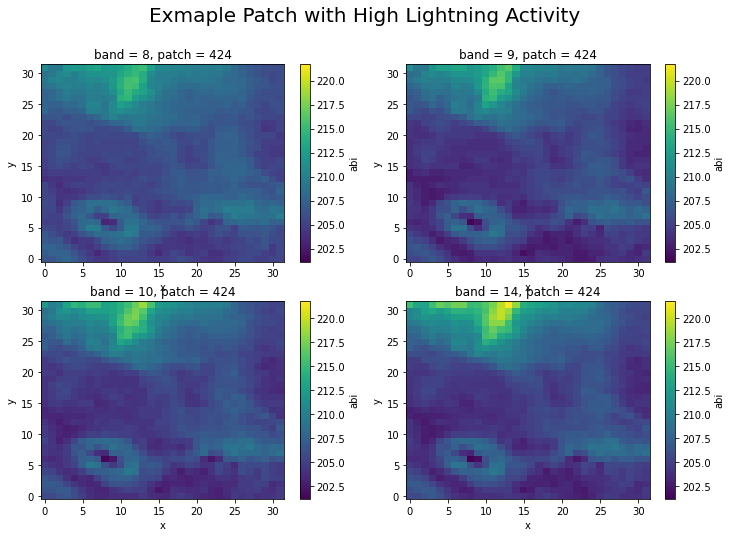

In [7]:
high_lc_indices = np.argwhere(train.flash_counts.values > 100).flatten() # indices with more than 100 lightning counts
no_lc_indices = np.argwhere(train.flash_counts.values == 0).flatten() # indices with no lightning counts

index = high_lc_indices[205]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range  
vmax = train['abi'][index,:,:,:].max()

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with High Lightning Activity', fontsize=20)

Areas without lightning activity often exibit a much larger BT range throughout the channel column, particularily the longwave window (Band 14) which often has much higher values with clear skies.

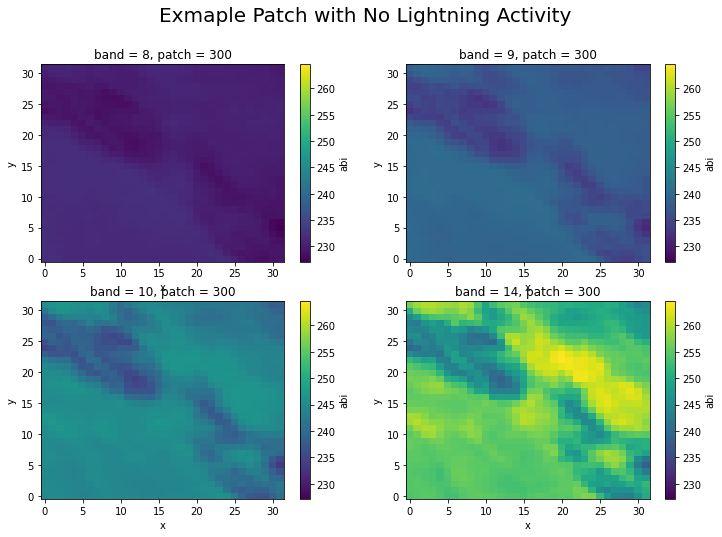

In [8]:
index = no_lc_indices[300]
vmin = train['abi'][index,:,:,:].min() # set min/max plotting range
vmax = train['abi'][index,:,:,:].max() # set min/max plotting range

fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    train['abi'][index,i,:,:].plot(ax=ax.ravel()[i], vmin=vmin, vmax=vmax)
    plt.suptitle('Exmaple Patch with No Lightning Activity', fontsize=20)

This pattern is also noted when taking the mean value of each patch across the dataset.

In [9]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
#mean_patches_lc = lc_train.abi.mean(dim=('x','y')) # mean BT of each patch
#mean_patches_no_lc = no_lc_train.abi.mean(dim=('x','y')) # mean BT of each patch

#fig, ax = plt.subplots(2,1, figsize=(12,12))
#for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):
#    if i < 4:
#        sns.kdeplot(mean_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
#            'Mean Patch Distributions With Lightning Activity', fontsize=22)
#    else:
#        sns.kdeplot(mean_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
#            'Mean Patch Distributions Without Lightning Activity', fontsize=22)

In [10]:
# Metric functions
from sklearn.metrics import confusion_matrix, mean_squared_error, brier_score_loss, roc_auc_score

import numpy as np

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def auc_score(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def brier_score(y_true, y_pred):
    return brier_score_loss(y_true, y_pred)

def brier_skill_score(y_true, y_pred):
    
    model_brier_score = mean_squared_error(y_true, y_pred)
    climo_brier_score = mean_squared_error(y_true, np.ones(y_true.size) * y_true.sum() / y_true.size)
    model_brier_skill_score = 1 - model_brier_score / climo_brier_score
    return model_brier_skill_score

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def peirce_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (no * no).sum() / n ** 2)

def heidke_skill_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    n = float(cm.sum())
    nf = cm.sum(axis=0)
    no = cm.sum(axis=1)
    correct = float(cm.trace())
    return (correct / n - (nf * no).sum() / n ** 2) / (1 - (nf * no).sum() / n ** 2)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def create_metric_dict(label,y_true,y_pred,y_bin):
    m = dict()
    m['label'] = label
    m['rmse'] = root_mean_squared_error(y_true, y_pred)
    m['r2'] = r2_corr(y_true, y_pred)
    m['hellinger_distance']= hellinger_distance(y_true, y_pred)
    m['heidke_ss'] = heidke_skill_score(y_true, y_bin)
    m['pierce_ss'] = peirce_skill_score(y_true, y_bin)
    m['brier_score'] = brier_score(y_true, y_bin)
    m['brier_ss'] = brier_skill_score(y_true, y_bin)
    #m['AUC'] = roc_auc_score(val_out, binary_preds)
    m['AUCbug'] = roc_auc_score(y_true, y_bin)
    m['AUC'] = roc_auc_score(y_true, y_pred)

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    m['fpr'] = fpr
    m['tpr'] = tpr
    m['thresholds'] = thresholds
    return m 


In [11]:
# Visual of input variable before and after transform
# Example of data transform procedure for dataset

### Data Transforms
Discuss any transforms or normalizations that may be needed for this dataset. Remember to fit a scaler only to the training data and then apply it on testing and validation.

## Interpretation
Description of interpretation methods for problem

In [12]:
# Include examples of interpretation code
#import pickle as pickle
#with open('abi_data.pkl','wb') as f:
##    pickle.dump(train_in,f)
#   pickle.dump(train_out,f)
#    pickle.dump(val_in,f)
#    pickle.dump(val_out,f)
    

## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

In [13]:
%%time
# Monday's code goes here

# Make sure each time you run you prepare the datasets 

# get numpy arrays of patch data for each band (this also converts all flash_counts to binary classes)
train_in, train_out = prepare_data(train) 
val_in, val_out = prepare_data(val)
test_in, test_out = prepare_data(test)

scaler = MinMaxScaler2D()
scaled_train_in = scaler.fit_transform(train_in)
scaled_val_in = scaler.transform(val_in)
scaled_test_in = scaler.transform(test_in)

#---1D methods
run_linear=True
run_logistic=True
run_xgb=True
run_mlp=True
#---2D methods
run_cnn=True

#---1D methods 
run_linear=False
run_logistic=False
run_xgb=False
run_mlp=False
run_nb=False
#---2D methods
run_cnn=False
#---resnet methods 
#   baseline, log()->MinMax, StdScaler, PCA
run_resnet = [False,False,False,True]
run_resnet = [True,False,False,False]
run_resnet = [False,False,True,False]
run_resnet = [False,True,False,False]

#---only run one at a time
#   
#   1) scaling in some of these affects resnets which follow
#
#   2) kernel with crash with more than a couple of any of these at a time.  The 2D image methods take up more 
#   memory and cause the kernel to crash if more than one or two are run at a time 

# For 1-D Models we have to select what predictors will be used
# here I select either 
# 1: min Tbs for each channel in each 32x32 patch - 4 predictors
# 2: (min, Q1, Media) Tbs for each channel in each 32x32 patch - 4*3 predictors
P1D_PredictorSelect=1
if P1D_PredictorSelect == 1:
    P1D_ModelStr = 'minPred'
else: 
    P1D_ModelStr = 'percPred'

CPU times: user 1min 53s, sys: 12.3 s, total: 2min 5s
Wall time: 2min 24s


In [14]:
# Monday's code goes here
# Exploratory Visualization of the data
from sklearn.inspection import plot_partial_dependence
def plot_pdp(model,X,image_name):
    features = [0, 1, (0, 1)]
    features = np.arange(X.shape[-1])
    print(features,X.shape)
    plot_partial_dependence(model, X, features, n_jobs=-1,grid_resolution=20)
    plt.savefig(image_name) 

In [15]:
lc_train = train.isel(patch=high_lc_indices) # all patch data with lightning counts (above threshold)
no_lc_train = train.isel(patch=no_lc_indices) # all patch data without lightning activity
sdv_patches_lc = lc_train.abi.std(dim=('x','y')) # mean BT of each patch
sdv_patches_no_lc = no_lc_train.abi.std(dim=('x','y')) # mean BT of each patch

/opt/conda/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


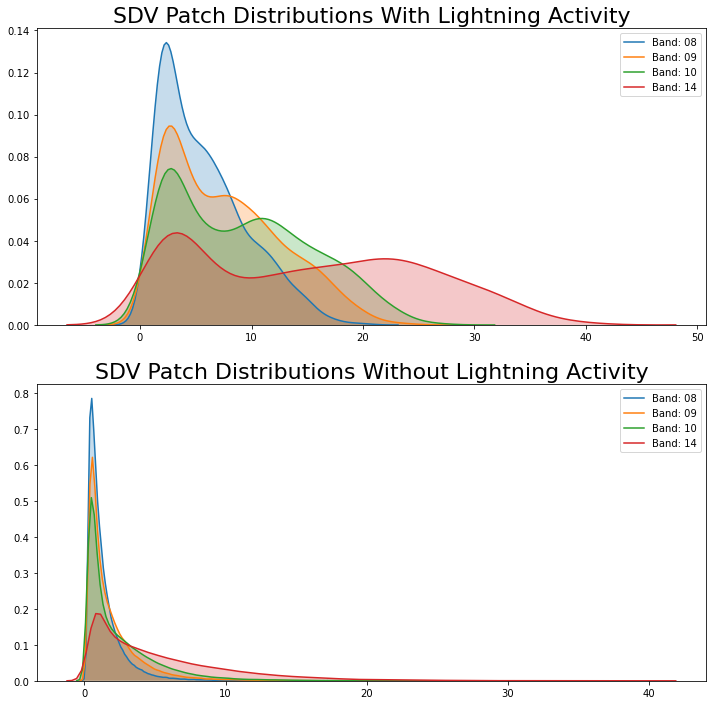

In [16]:
fig, ax = plt.subplots(2,1, figsize=(12,12))
for i,lab in enumerate(['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']*2):

    if i < 4:
        sns.kdeplot(sdv_patches_lc[:,i], ax=ax[0], label=lab, shade=True).set_title(
            'SDV Patch Distributions With Lightning Activity', fontsize=22)
    else:
        sns.kdeplot(sdv_patches_no_lc[:,i-4], ax=ax[1], label=lab, shade=True).set_title(
            'SDV Patch Distributions Without Lightning Activity', fontsize=22)
plt.savefig('sdv_explore.png')

In [17]:
#fig, ax = plt.subplots(4,1, figsize=(12,12))
skip_joint_plots = True
if not skip_joint_plots:
    band_names = ['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']
    cmaps = ["Greens","Blues","Reds","Purples"]
    print(mean_patches_lc)
    index = [0,1,2,3]
    index_b = [8,9,10,14]
    fig, axs = plt.subplots(4,4, figsize=(12,12))
    for i,lab in enumerate(band_names):
        index = np.arange(4)
        index_else = np.delete(index,i)
    #    ax.set_aspect("equal")
        for j in list(index_else):
            ib1 = index_b[i]
            ib2 = index_b[j] 
            x = mean_patches_lc.sel(band=ib1)
            y = mean_patches_lc.sel(band=ib2)
            idx = (np.isfinite(x) & np.isfinite(y))
            g = sns.kdeplot(x[idx],y[idx], ax=axs[i,j],label=band_names[j],cmap=cmaps[j], shade=True,shade_lowest=False)
            g.set_xlabel(band_names[i])
            g.set_ylabel(band_names[j])
        axs[i,i].axis('off')
    plt.suptitle('Joint Density of Mean Patches with Lightning Activity', fontsize=20)
    plt.savefig('high_lightning_jointdensities.png')

In [18]:
#fig, ax = plt.subplots(4,1, figsize=(12,12))
if not skip_joint_plots:
    plt.close()
    plt.clf()
    band_names = ['Band: 08', 'Band: 09', 'Band: 10', 'Band: 14']
    cmaps = ["Greens","Blues","Reds","Purples"]
    print(mean_patches_lc)
    index = [0,1,2,3]
    index_b = [8,9,10,14]
    fig, axs = plt.subplots(4,4, figsize=(12,12))
    for i,lab in enumerate(band_names):
        index = np.arange(4)
        index_else = np.delete(index,i)
    #    ax.set_aspect("equal")
        print('here',i,lab)
        for j in list(index_else):
            ib1 = index_b[i]
            ib2 = index_b[j] 
            x = mean_patches_no_lc.sel(band=ib1)
            y = mean_patches_no_lc.sel(band=ib2)
            idx = (np.isfinite(x) & np.isfinite(y))
            g = sns.kdeplot(x[idx],y[idx], ax=axs[i,j],label=band_names[j],cmap=cmaps[j], shade=True,shade_lowest=False)
            g.set_xlabel(band_names[i])
            g.set_ylabel(band_names[j])
        axs[i,i].axis('off')
    plt.suptitle('Joint Density of Mean Patches with No Lightning Activity', fontsize=20)
    plt.savefig('no_lightning_jointdensities.png')

# figure comments
Figures above confirm that the distributions of Tbs are highly correlated - they share common information across the ABI spectrum with respect to lightning (yes/no).  PCA of the ABI channel Tbs confirms this as the first PC explains ~95% of the variance across all training samples, the second ~5%.  We could use this finding to reduce the dimensionality of the network architectures by either averaging over all channels or by representing the input signal using 1 or 2 PCs rather than the 4 brightness temperatures.  

Distributions for with and without lightning are different.  With lighting distributions tend to fall on a 1-1 line, while distributions for without lightning show some skew.  Without Lightning, the window channel distributions shows cold tail which is somewhat expected.  the water channel weighting functions peak in the Mid-to-upper troposphere, while the window channel sensitivity peaks where the signal saturates - cloudtop or surface.  For clouds in the lower troposphere the window channel will reflect that signal (emission from cold cloud top), while the water bands won't directly sense the surface or cloud; hence the skew toward colder temps in the window band. 

In [19]:
from sklearn import metrics
import pickle as pickle


# 1-D Models

# Decision Tree

In [20]:
!pip install xgboost
import xgboost as xgb

In [21]:
#---Gaussian Naive Bayes
if run_nb:
    from sklearn.naive_bayes import GaussianNB

    # on non-standardized data
    gnb = GaussianNB()
    npa, nx, ny, nc = train_in.shape
    npv, nx, ny, nc = val_in.shape
    npt, nx, ny, nc = test_in.shape
    #--- could use percentiles of each patch (min, Q1, Median) why not?
    #    4 channels * npercentiles as predictors
    if P1D_PredictorSelect == 2:
#        pc_patch = np.percentile(scaled_train_in,(0,25,50),axis=(1,2))
#        pc_val_patch = np.percentile(scaled_val_in,(0,25,50),axis=(1,2))
#        pc_test_patch = np.percentile(scaled_test_in,(0,25,50),axis=(1,2))
        pc_patch = np.percentile(train_in,(0,25,50),axis=(1,2))
        pc_val_patch = np.percentile(val_in,(0,25,50),axis=(1,2))
        pc_test_patch = np.percentile(test_in,(0,25,50),axis=(1,2))
        # concatenate percentiles for each channel onto each other
        pc_patch = np.c_[pc_patch[0,:,:],pc_patch[1,:,:],pc_patch[2,:,:]]
        pc_val_patch = np.c_[pc_val_patch[0,:,:],pc_val_patch[1,:,:],pc_val_patch[2,:,:]]
        pc_test_patch = np.c_[pc_test_patch[0,:,:],pc_test_patch[1,:,:],pc_test_patch[2,:,:]]
        min_patch = pc_patch
        min_val_patch = pc_val_patch
        min_test_patch = pc_test_patch
        n_estimators = 30
        # for percentiles more estimators -> still decreasing at 20
    else:
        #---use the minimum Tb in each patch as a predictor
        min_patch = np.min(scaled_train_in,axis=(1,2))
        min_val_patch = np.min(scaled_val_in,axis=(1,2))    
        min_test_patch = np.min(scaled_test_in,axis=(1,2))

    # scale data
#    fit = gnb.fit(train_in.reshape((npa*nx*ny,nc)),train_out)
    
#    preds_test = gnb.predict_proba(test_in.reshape((npt*nx*ny,nc)))
#   preds_binary_test = gnb.predict(test_in.reshape((npt*nx*ny,nc)))
    fit = gnb.fit(min_patch,train_out)
    
    preds_test = gnb.predict_proba(min_test_patch)
    binary_preds_test = gnb.predict(min_test_patch)
    preds_test = preds_test[:,1]

    preds = gnb.predict_proba(min_val_patch)
    binary_preds = gnb.predict(min_val_patch)
    preds = preds[:,1]
    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(test_out, preds_test),3)))
    print('R squared: {}'.format(np.round(r2_corr(test_out, preds_test),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(test_out, preds_test),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(test_out, binary_preds_test),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(test_out, binary_preds_test),3)))
    print('Brier Score: {}'.format(np.round(brier_score(test_out, binary_preds_test),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(test_out, binary_preds_test),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(test_out, binary_preds_test),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(test_out, preds_test),3)))

    m = dict()
    label = 'GNB'
    model_all = []
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'GNB_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)
    import pickle as pickle
    gnb_file = './metrics/{}_gnb_models.pkl'.format(P1D_ModelStr)
    with open(gnb_file,'wb') as f:
        pickle.dump(model_all,f)
    

In [22]:
if run_xgb:
    # 1D - models
    model_all = []
    import xgboost as xgb
    import numpy as np
    loss_type = 'mse'
    eval_metric = 'rmse'
    n_estimators = 30
    # with more than 20 estimators it looks like its over fitting with classifier
    # with ~>20 for regression
    learning_rate = 0.10
    max_depth = 8
    channel_select = 0

    print(train_out.shape,val_out.shape)
    #binary_threshold = 0.5
    #binary_train_out = np.where(train_out >= binary_threshold, 1, 0)
    #binary_val_out = np.where(val_out >= binary_threshold, 1, 0)

    #--- could use percentiles of each patch (min, Q1, Median) why not?
    #    4 channels * npercentiles as predictors
    if P1D_PredictorSelect == 2:
        pc_patch = np.percentile(scaled_train_in,(0,25,50),axis=(1,2))
        pc_val_patch = np.percentile(scaled_val_in,(0,25,50),axis=(1,2))
        pc_test_patch = np.percentile(scaled_test_in,(0,25,50),axis=(1,2))
        # concatenate percentiles for each channel onto each other
        pc_patch = np.c_[pc_patch[0,:,:],pc_patch[1,:,:],pc_patch[2,:,:]]
        pc_val_patch = np.c_[pc_val_patch[0,:,:],pc_val_patch[1,:,:],pc_val_patch[2,:,:]]
        pc_test_patch = np.c_[pc_test_patch[0,:,:],pc_test_patch[1,:,:],pc_test_patch[2,:,:]]
        min_patch = pc_patch
        min_val_patch = pc_val_patch
        min_test_patch = pc_test_patch
        n_estimators = 30
        # for percentiles more estimators -> still decreasing at 20
    else:
        #---use the minimum Tb in each patch as a predictor
        min_patch = np.min(scaled_train_in,axis=(1,2))
        min_val_patch = np.min(scaled_val_in,axis=(1,2))    
        min_test_patch = np.min(scaled_test_in,axis=(1,2))

    print(min_patch.shape)    
    #---off the shelf classifier (binary: logistic)
    #regression = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
    #                               random_state=42, verbose=1, n_jobs=32)
    regression = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                                               random_state=42, loss=loss_type, verbose=1, n_jobs=32)
    #history = regression.fit(min_patch, train_out,
    #                         eval_set=[(min_patch, train_out),(min_val_patch, val_out)],
    #                         eval_metric=eval_metric, verbose=True)
    history = regression.fit(min_patch, train_out,
                             eval_set=[(min_patch, train_out),(min_val_patch, val_out)],
                             eval_metric=eval_metric, verbose=True)

    evals_result = regression.evals_result()

    #from xgboost import plot_tree
    test_score  = np.array(evals_result['validation_1']['rmse'])
    train_score = np.array(evals_result['validation_0']['rmse'])
    test_score  = test_score*test_score
    train_score = train_score*train_score

    def plot_model_loss(loss_train,loss_test,imgname):
      # make importances relative to max importance
      plt.plot(loss_train,'r',label='training loss')
      plt.plot(loss_test,'b',label='testing loss')
      plt.xlabel('Boosting Iterations')
      plt.title('Model Loss')
      plt.ylabel('Model Loss')
      plt.yscale('log')
      plt.savefig(imgname)
      plt.legend(fontsize=8)
    imgname = '{}_XGB_loss_regressor.png'.format(P1D_ModelStr)
    plot_model_loss(train_score,test_score,imgname)

    preds = regression.predict(min_val_patch)
    binary_threshold = 0.5
    print(preds,np.min(preds),np.max(preds))
    preds_test = regression.predict(min_test_patch)
    binary_preds_test = np.where(preds_test >= binary_threshold, 1, 0)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)

    #preds = regression.predict_proba(min_val_patch)
    #preds = preds[:,1]

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    m = dict()

    label = 'xgb_regressor'
#    image_name="./images/{}_pdp.png".format(label)
    image_name="./images/{}_{}_pdp.png".format(P1D_ModelStr,label)
    plot_pdp(regression,min_patch,image_name)

    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'xgb_regressor_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)

In [23]:
if run_xgb:
    loss_type = 'mse'
    eval_metric = 'rmse'
    learning_rate = 0.10
    max_depth = 8
    channel_select = 0

    #---off the shelf classifier (binary: logistic)
    regression = xgb.XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
                                   random_state=42, verbose=1, n_jobs=32)
    #regression = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth,
    #                                           random_state=42, loss=loss_type, verbose=1, n_jobs=32)
    #history = regression.fit(min_patch, train_out,
    #                         eval_set=[(min_patch, train_out),(min_val_patch, val_out)],
    #                         eval_metric=eval_metric, verbose=True)
    print("min_patch=",train_in.shape, scaled_train_in.shape, min_patch.shape)    
    history = regression.fit(min_patch, train_out,
                             eval_set=[(min_patch, train_out),(min_val_patch, val_out)],
                             eval_metric=eval_metric, verbose=True)

    evals_result = regression.evals_result()

    #from xgboost import plot_tree
    test_score  = np.array(evals_result['validation_1']['rmse'])
    train_score = np.array(evals_result['validation_0']['rmse'])
    test_score  = test_score*test_score
    train_score = train_score*train_score

    def plot_model_loss(loss_train,loss_test,imgname):
      # make importances relative to max importance
      plt.plot(loss_train,'r',label='training loss')
      plt.plot(loss_test,'b',label='testing loss')
      plt.xlabel('Boosting Iterations')
      plt.title('Model Loss')
      plt.ylabel('Model Loss')
      plt.yscale('log')
      plt.savefig(imgname)
      plt.legend(fontsize=8)
    imgname = 'XGB_loss_classifier.png'
    imgname = '{}_XGB_loss_classifier.png'.format(P1D_ModelStr)

    plot_model_loss(train_score,test_score,imgname)


    preds = regression.predict(min_val_patch)
    preds_test = regression.predict(min_test_patch)
    binary_preds_test = np.where(preds_test >= binary_threshold, 1, 0)

    print(preds.shape)
    print(preds)
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    preds = regression.predict_proba(min_val_patch)
    preds = preds[:,1]
    preds_test = regression.predict_proba(min_test_patch)
    preds_test = preds_test[:,1]

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    label = 'xgb_classifier'
    image_name="./images/{}_{}_pdp.png".format(P1D_ModelStr,label)
    plot_pdp(regression,min_patch,image_name)

    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'xgb_classifier_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)

    print(model_all)
    import pickle as pickle
    xgb_file = './metrics/{}_xgb_models.pkl'.format(P1D_ModelStr)
    with open(xgb_file,'wb') as f:
        pickle.dump(model_all,f)

# Statistical Summary for XGB classifier
| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.362|
|              | R2: |0.525 |
|              | Hellenger Distance: |0.0|
|||
| Classified   |||
|              | Heidke Skill Score: |0.725|
|              | Peirce Skill Score:  |0.722|
|              | Brier Score: |0.131|
|              | Brier Skill Score: |0.451|
|              | AUC: |0.861|

# try a linear method - linear regression

In [24]:
if run_linear:
    from sklearn.linear_model import LinearRegression
    C_regularization = .10
    C_regularization = 1.0
    #----C_regularization
    linear = LinearRegression(normalize=True)
    npatch, nx, ny, nc = scaled_train_in.shape 
    npatch_val, nx, ny, nc = scaled_val_in.shape 

    print(min_patch.shape,train_out.shape,np.min(train_out),np.max(train_out))
    linear.fit(min_patch, train_out)
    preds = linear.predict(min_val_patch)
    binary_threshold = 0.5
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    preds_test = regression.predict(min_test_patch)
    binary_preds_test = np.where(preds_test >= binary_threshold, 1, 0)

    plt.plot(preds,val_out,'.')
    print( np.sqrt(np.mean( (preds-val_out)*(preds-val_out) ))) 

    #print(binary_preds_c1.shape,np.min(binary_preds_c1),np.max(binary_preds_c1),min_val_patch.shape)
    #print(preds.shape,np.min(preds),np.max(preds))
    #print(preds)


    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    model_all = []
    label = 'linear'
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'linear_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)
    import pickle as pickle
    linear_file = './metrics/{}_linear_models.pkl'.format(P1D_ModelStr)

    with open(linear_file,'wb') as f:
        pickle.dump(model_all,f)

# try a linear method (yes logistic regression is linear)

In [25]:
if run_logistic:
    from sklearn.linear_model import LogisticRegression
    C_regularization = .10
    C_regularization = 1.0
    #----C_regularization
    logistic = LogisticRegression(max_iter=10000, tol=1e-6, C=C_regularization, verbose=1)
    npatch, nx, ny, nc = scaled_train_in.shape 
    npatch_val, nx, ny, nc = scaled_val_in.shape 

    print(min_patch.shape,train_out.shape,np.min(train_out),np.max(train_out))
    logistic.fit(min_patch, train_out)
    binary_preds = logistic.predict(min_val_patch)
    preds = logistic.predict_proba(min_val_patch)
    preds_test = logistic.predict_proba(min_test_patch)


    #print(binary_preds_c1.shape,np.min(binary_preds_c1),np.max(binary_preds_c1),min_val_patch.shape)
    #print(preds.shape,np.min(preds),np.max(preds))
    #print(preds)

    preds = preds[:,1].squeeze()
    preds_test = preds_test[:,1].squeeze()
    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    model_all = []
    m = dict()
    label = 'logistic'
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'logistic_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)

    import pickle as pickle
    logistic_file = './metrics/{}_logistic_models.pkl'.format(P1D_ModelStr)

    with open(logistic_file,'wb') as f:
        pickle.dump(model_all,f)

# Multi-Layer Perceptron (Densely Connected) Classifier

In [26]:
if run_mlp:
    # Tuesday's code goes here
    from sklearn.neural_network import MLPClassifier
    hidden_layer_sizes = (20,20)
    # larger network 100,100 takes a really long time and results aren't great after 30 iterations
    mlpC = MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=hidden_layer_sizes,verbose=True)
    mlpC.fit(min_patch, train_out)
    binary_preds = mlpC.predict(min_val_patch)
    preds = mlpC.predict_proba(min_val_patch)
    preds_test = mlpC.predict_proba(min_test_patch)


    preds = preds[:,1].squeeze()
    preds_test = preds_test[:,1].squeeze()
    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    model_all = []

    label = 'mlp_classifier'
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'mlp_classifier_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)
    import pickle as pickle
    mlp_file = './metrics/{}_mlp_models.pkl'.format(P1D_ModelStr)

    with open(mlp_file,'wb') as f:
        pickle.dump(model_all,f)

# convolutional network

In [27]:
if run_cnn:
    from sklearn import metrics
    #convNet_mod = StandardConvNet(epochs=5, batch_size=512)
    #convNet_mod = StandardConvNet(epochs=5, batch_size=512, loss='binary_crossentropy', metrics=['MeanSquaredError',
    #                                                                                            'AUC','Accuracy'])
    convNet_mod = StandardConvNet(epochs=5, batch_size=512, loss='mse', metrics=['MeanSquaredError',
                                                                                 'AUC','Accuracy'])
    vars(convNet_mod)

    # Fit model and print architecture
    convNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
    convNet_mod.model.summary()

    print(convNet_mod.model.history.history)
    train_loss = convNet_mod.model.history.history['loss']
    val_loss = convNet_mod.model.history.history['val_loss']
    train_mse = convNet_mod.model.history.history['mean_squared_error']
    val_mse = convNet_mod.model.history.history['val_mean_squared_error']
    train_auc = convNet_mod.model.history.history['auc']
    val_auc = convNet_mod.model.history.history['val_auc']

    fig, axs = plt.subplots(3,1, figsize=(12,12))
    axs[0].plot(train_loss,label='train loss')
    axs[0].plot(val_loss,label='val loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(fontsize=10)
    axs[1].plot(train_auc,label='train auc')
    axs[1].plot(val_auc,label='val auc')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(fontsize=10)
    axs[2].plot(train_mse,label='train mse')
    axs[2].plot(val_mse,label='val mse')
    axs[2].legend(fontsize=10)
    axs[2].set_xlabel('Epoch')


    # set the probability threshold for binary classification; predict on validation; add binary preds
    binary_threshold = 0.5
    preds = convNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    preds_test = convNet_mod.predict(scaled_test_in).reshape(test_out.shape[0])
    binary_preds_test = np.where(preds_test >= binary_threshold, 1, 0)
    print(preds)
    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, preds),3)))
    #print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))

    model_all = []
    m = dict()
    label = 'StandardCNN'
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'StandardCNN_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)

    with open('./metrics/cnn_models.pkl','wb') as f:
        pickle.dump(model_all,f)


    print(convNet_mod.model.losses)
    print(convNet_mod.model.history.history)

# Statistical Summary for Standard CNN classifier
| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.305|
|              | R2: |0.619 |
|              | Hellenger Distance: |0.593|
|||
| Classified   |||
|              | Heidke Skill Score: |0.746|
|              | Peirce Skill Score:  |0.75|
|              | Brier Score: |0.122|
|              | Brier Skill Score: |0.49|
|              | AUC: |0.875|

## Baseline ResNet Evaluation Metrics
We trained on binary output data, but output probabilities before converting to class. This allows us to evaluate regressed and classified metrics:


| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.328|
|              | R2: |0.567 |
|              | Hellenger Distance: |0.501|
|||
| Classified   |||
|              | Heidke Skill Score: |0.705|
|              | Peirce Skill Score:  |0.713|
|              | Brier Score: |0.143|
|              | Brier Skill Score: |0.402|
|              | AUC: |0.856|

# Resnets

In [28]:
num_epochs = 5
# results are not consistent with the res-net or cnn included in goes16ci for more than ~5 epochs ... optimization 
# starts banging around ... need to save best weights for inference mode rather than last weights

if run_resnet[0]:
    # scale data
    # declare ResNet (residual network from the goes16i module) and list the default parameters
    # Any of these parameters can be overridden
    # note using larger batch sizes here can cause memory errors
    resNet_mod = ResNet(epochs=num_epochs, batch_size=512, metrics=['MeanSquaredError',
                                                                                 'AUC','Accuracy'])
    vars(resNet_mod)

    # Fit model and print architecture
    resNet_mod.fit(scaled_train_in, train_out, scaled_val_in, val_out)
    resNet_mod.model.summary()

    # set the probability threshold for binary classification; predict on validation; add binary preds
    binary_threshold = 0.5
    preds = resNet_mod.predict(scaled_val_in).reshape(val_out.shape[0])
    binary_preds = np.where(preds >= binary_threshold, 1, 0)
    preds_test = resNet_mod.predict(scaled_test_in).reshape(test_out.shape[0])
    binary_preds_test = np.where(preds_test >= binary_threshold, 1, 0)

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, preds),3)))
    #m['AUC'] = roc_auc_score(val_out, binary_preds)
    model_all = []

    label = 'ResNet'
    m = create_metric_dict(label,val_out,preds,binary_preds)
    model_all.append(m)
    label = 'ResNet_test'
    m = create_metric_dict(label,test_out,preds_test,binary_preds_test)
    model_all.append(m)
    import pickle as pickle
    with open('./metrics/resnet_models.pkl','wb') as f:
        pickle.dump(model_all,f)

if run_resnet[1]:
    # scale data
    scaler = MinMaxScaler2D()
    scaled_train_in = scaler.fit_transform(np.log(train_in))
    scaled_val_in = scaler.transform(np.log(val_in))
    scaled_test_in = scaler.transform(np.log(test_in))

    resNet_mod2 = ResNet(epochs=num_epochs, batch_size=512, metrics=['MeanSquaredError',
                                                                                 'AUC','Accuracy'])
    vars(resNet_mod2)

    #Fit new model using standardized predictors - likely won't work

    # Fit model and print architecture
    resNet_mod2.fit(scaled_train_in, train_out, scaled_val_in, val_out)
    resNet_mod2.model.summary()
    # set the probability threshold for binary classification; predict on validation; add binary preds
    binary_threshold = 0.5
    preds2 = resNet_mod2.predict(scaled_val_in).reshape(val_out.shape[0])
    preds2_test = resNet_mod2.predict(scaled_test_in).reshape(test_out.shape[0])
    binary_preds2 = np.where(preds2 >= binary_threshold, 1, 0)
    binary_preds2_test = np.where(preds2_test >= binary_threshold, 1, 0)

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds2),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds2),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds2),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds2),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds2),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds2),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds2),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds2),3)))

    m = dict()
    model_all = []
    label = 'logscaled-ResNet'
    m = create_metric_dict(label,val_out,preds2,binary_preds2)
    model_all.append(m)
    label = 'logscaled-ResNet_test'
    m = create_metric_dict(label,test_out,preds2_test,binary_preds2_test)
    model_all.append(m)
    import pickle as pickle
    with open('./metrics/logresnet_models.pkl','wb') as f:
        pickle.dump(model_all,f)
        
if run_resnet[2]:
    from sklearn.preprocessing import StandardScaler
    scalerstd = StandardScaler()
    npa, nx, ny, nc = train_in.shape
    npv, nx, ny, nc = val_in.shape
    npt, nx, ny, nc = test_in.shape

    # scale data
    scaled_train_in = scalerstd.fit_transform(train_in.reshape((npa*nx*ny,nc))).reshape((npa,nx,ny,nc))
    scaled_val_in   = scalerstd.transform(val_in.reshape((npv*nx*ny,nc))).reshape((npv,nx,ny,nc))
    scaled_test_in   = scalerstd.transform(test_in.reshape((npt*nx*ny,nc))).reshape((npt,nx,ny,nc))
    resNet_mod2 = ResNet(epochs=num_epochs, batch_size=512, metrics=['MeanSquaredError',
                                                                                 'AUC','Accuracy'])
    vars(resNet_mod2)

    # Fit model and print architecture
    resNet_mod2.fit(scaled_train_in, train_out, scaled_val_in, val_out)
    resNet_mod2.model.summary()
    # set the probability threshold for binary classification; predict on validation; add binary preds
    binary_threshold = 0.5
    preds2 = resNet_mod2.predict(scaled_val_in).reshape(val_out.shape[0])
    preds2_test = resNet_mod2.predict(scaled_test_in).reshape(test_out.shape[0])
    binary_preds2 = np.where(preds2 >= binary_threshold, 1, 0)
    binary_preds2_test = np.where(preds2_test >= binary_threshold, 1, 0)

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds2),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds2),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds2),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds2),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds2),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds2),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds2),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds2),3)))

    m = dict()
    model_all = []
    label = 'stdscaled-ResNet'
    m = create_metric_dict(label,val_out,preds2,binary_preds2)
    model_all.append(m)
    label = 'stdscaled-ResNet_test'
    m = create_metric_dict(label,test_out,preds2_test,binary_preds2_test)
    model_all.append(m)
    import pickle as pickle
    with open('./metrics/stdresnet_models.pkl','wb') as f:
        pickle.dump(model_all,f)
        
if run_resnet[3]:
    #---use PCA to perform dimensionality reduction of ABI rescaled Tbs
    from sklearn.decomposition import PCA
    npa, nx, ny, nc = scaled_train_in.shape 
    npv, nx, ny, nc = scaled_val_in.shape
    npt, nx, ny, nc = scaled_test_in.shape
    #---reform arrays into 2D - number of samples x 2d patch sizes, n bands
    n_components = 4
    #print(pca.explained_variance_ratio_)
    #print(pca.singular_values_)
    # explained variance = 9.94144759e-01 5.54575925e-03 2.95567851e-04 1.39137032e-05
    # first singular value explains 99.4% of variance in dataset
    #  due to fact that water channels are spectrally correlated 
    #  see figure above - distributions are similar but mean values are 
    #  displaced -> their weighting functions peak at different altitudes
    #  B8 highest (coldest), B10 lower (warmest)
    #---could truncate inputs to 2 PCs

    n_components = 2
    pca = PCA(n_components=n_components)
    print("computing PCA")
    nsubsamp_pca = 10
    npa_ss = npa // nsubsamp_pca + 1 
    print(npa_ss,scaled_train_in[::nsubsamp_pca,:,:,:].shape)
    pca.fit(scaled_train_in[::nsubsamp_pca,:,:,:].reshape((npa_ss*nx*ny,nc)))
    scaled_train_in = pca.transform(scaled_train_in.reshape((npa*nx*ny,nc))).reshape((npa,nx,ny,n_components))
    print("transforming Val PCA")
    scaled_val_in = pca.transform(scaled_val_in.reshape((npv*nx*ny,nc))).reshape((npv,nx,ny,n_components))
    print("transforming Test PCA")
    scaled_test_in = pca.transform(scaled_test_in.reshape((npt*nx*ny,nc))).reshape((npt,nx,ny,n_components))

    resNet_mod2 = ResNet(epochs=num_epochs, batch_size=512, metrics=['MeanSquaredError',
                                                                                 'AUC','Accuracy'])
    vars(resNet_mod2)

    # Fit model and print architecture
    resNet_mod2.fit(scaled_train_in, train_out, scaled_val_in, val_out)
    resNet_mod2.model.summary()
    # set the probability threshold for binary classification; predict on validation; add binary preds
    binary_threshold = 0.5
    preds2 = resNet_mod2.predict(scaled_val_in).reshape(val_out.shape[0])
    preds2_test = resNet_mod2.predict(scaled_test_in).reshape(test_out.shape[0])
    binary_preds2 = np.where(preds2 >= binary_threshold, 1, 0)
    binary_preds2_test = np.where(preds2_test >= binary_threshold, 1, 0)

    # Example regressed metrics
    print('RMSE: {}'.format(np.round(root_mean_squared_error(val_out, preds2),3)))
    print('R squared: {}'.format(np.round(r2_corr(val_out, preds2),3)))
    print('Hellenger Distance: {}'.format(np.round(hellinger_distance(val_out, preds2),3)))

    # Example classified metrics
    print('Heidke Skill Score: {}'.format(np.round(heidke_skill_score(val_out, binary_preds2),3)))
    print('Pierce Skill Score: {}'.format(np.round(peirce_skill_score(val_out, binary_preds2),3)))
    print('Brier Score: {}'.format(np.round(brier_score(val_out, binary_preds2),3)))
    print('Brier Skill Score: {}'.format(np.round(brier_skill_score(val_out, binary_preds2),3)))
    print('AUC: {}'.format(np.round(roc_auc_score(val_out, binary_preds2),3)))

    m = dict()
    model_all = []
    label = 'pcascaled-ResNet'
    m = create_metric_dict(label,val_out,preds2,binary_preds2)
    model_all.append(m)
    label = 'pcascaled-ResNet_test'
    m = create_metric_dict(label,test_out,preds2_test,binary_preds2_test)
    model_all.append(m)
    import pickle as pickle
    with open('./metrics/pcaresnet_models.pkl','wb') as f:
        pickle.dump(model_all,f)

print("model =",model_all)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
{'loss': 0.08106677979230881, 'mean_squared_error': 0.08106677979230881, 'auc': 0.9455090761184692, 'accuracy': 0.004774134140461683, 'val_loss': 0.28441712260246277, 'val_mean_squared_error': 0.28441712260246277, 'val_auc': 0.8597640991210938, 'val_accuracy': 0.0}
{'loss': 0.06799767911434174, 'mean_squared_error': 0.06799767911434174, 'auc': 0.9636686444282532, 'accuracy': 0.00020695754210464656, 'val_loss': 0.10265175253152847, 'val_mean_squared_error': 0.10265175253152847, 'val_auc': 0.9392106533050537, 'val_accuracy': 0.0}
{'loss': 0.06439273804426193, 'mean_squared_error': 0.06439273804426193, 'auc': 0.967078447341919, 'accuracy': 0.00012699667422566563, 'val_loss': 0.5270196199417114, 'val_mean_squared_error': 0.5270196199417114, 'val_auc': 0.7271304726600647, 'val_accuracy': 0.1326385736465454}
{'loss': 0.06325559318065643, 'mean_squared_error': 0.06325559318065643, 'auc': 0.9679584503173828, 'accu

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [29]:
# Tuesday's code goes here
#print(212604*32*32*4,scaled_train_in.shape,npa,nx,ny,nc,435412992*2)

NameError: name 'npa' is not defined

# Statistical Summary for MLP classifier
| Type | Metric | Value to beat |
| ------------- | :----:|:-------|
|  Regressed   ||   
|              | RMSE: |0.854|
|              | R2: |0.596 |
|              | Hellenger Distance: |0.476|
|||
| Classified   |||
|              | Heidke Skill Score: |0.726|
|              | Peirce Skill Score:  |0.734|
|              | Brier Score: |0.132|
|              | Brier Skill Score: |0.447|
|              | AUC: |0.867|

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# Wednesday's code goes here
import pickle as pickle 
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt 
sns.reset_orig
sns.set_style("whitegrid")
def plot_1d(test_or_val,models,metric_path,plot_path):
    
    metrics_all = []
    n_metrics = []
    pivot = dict()
    f = plt.figure(figsize=(8,6))
    for iModel in range(len(models)):
        model_file = metric_path + models[iModel] + '_models.pkl'
        with open(model_file,'rb') as f:
            metric = pickle.load(f)
        n_metric = len(metric)
        n_metrics.append(n_metric)
        metrics_all.append(metric)
    #    print(models[iModel], n_metric)
    #    print(metric)
        # Now, plot the computed values
        for iModel2 in range(n_metric):
            m = metric[iModel2]
            if 'test' in test_or_val:
                if "_test" not in m['label']: continue 
                m['label'] = m['label'][0:-5]
            else:
                if "_test" in m['label']: continue 
            if 'mlp' in m['label']:
                m['label'] = 'MLPClas'
            if ('xgb' in m['label']) & ('reg' in m['label']):
                m['label'] = 'XGBRegr'
            if ('xgb' in m['label']) & ('clas' in m['label']):
                m['label'] = 'XGBClas'
            if 'minPred' in models[iModel]:
                m['label'] = 'minPred-' + m['label']
            else:
                m['label'] = 'percentilePred-' + m['label']
            print(iModel,iModel2,m['label'])
            if ('xgb' in models[iModel]) & ('XGB' not in m['label']): continue
            if AUCbug == True:
                m['AUC'] = m['AUCbug']
            print('%s ROC (area = %0.3f)'% (m['label'], m['AUC']))
            plt.plot(m['fpr'], m['tpr'], label='%s ROC (area = %0.3f)' % (m['label'], m['AUC']))
#            sns.plot(m['fpr'], m['tpr'], label='%s ROC (area = %0.3f)' % (m['label'], m['AUC']))
            pivot[m['label']] = [m['rmse'],m['r2'],m['hellinger_distance'],m['heidke_ss'],
                               m['pierce_ss'], m['brier_score'], m['brier_ss'], m['AUC']]
            if 'logis' in m['label']:
                break
    # Custom settings for the plot
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('{}/roc_curves_1d_{}.png'.format(plot_path,test_or_val))
    plt.clf()
    plt.close()


    df = pd.DataFrame(pivot)
    print(df)
    df.index = ['rmse','r2','hellinger_distance','heidke_ss','peirce_ss','brier_score','brier_ss','AUC']

    f = plt.figure(figsize=(10,10))
    g = sns.heatmap(
        df,
        square=True,
        cbar_kws={'fraction' : 0.01},
        cmap='OrRd',
        annot=True,
        fmt=".3f",
        linewidth=1
    )

    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')
    f.tight_layout()
    plt.savefig('{}/heatmap_summary_1d_{}.png'.format(plot_path,test_or_val))

    plt.clf()
    plt.close()
    sns.reset_orig

def plot_metrics(test_or_val,AUCbug,metric_path,plot_path):

    models = ['minPred_mlp','minPred_logistic','minPred_xgb','minPred_gnb','percPred_mlp','percPred_logistic','percPred_xgb','percPred_gnb']
    plot_1d(test_or_val,models,metric_path,plot_path)
    
    models = ['resnet','logresnet','stdresnet','pcaresnet','percPred_mlp','percPred_logistic','cnn','percPred_xgb']
    metrics_all = []
    n_metrics = []
    pivot = dict()
#    f = plt.figure(figsize=(10,10))
    f = plt.figure(figsize=(8,6))

    for iModel in range(len(models)):
        model_file = metric_path + models[iModel] + '_models.pkl'
        with open(model_file,'rb') as f:
            metric = pickle.load(f)
        n_metric = len(metric)
        n_metrics.append(n_metric)
        metrics_all.append(metric)
        #print(models[iModel], n_metric)
        #print(metric)
        # Now, plot the computed values
        for iModel2 in range(n_metric):
            m = metric[iModel2]
            if 'test' in test_or_val:
                if "_test" not in m['label']: continue 
                m['label'] = m['label'][0:-5]
            else:
                if "_test" in m['label']: continue 
            if m['label'] == 'ResNet':
                m['label'] = 'Baseline-ResNet'
            if 'logscal' in m['label']:
                m['label'] = 'LogTrans-ResNet'
            if 'pcascal' in m['label']:
                m['label'] = 'PCATrans-ResNet'
            if 'stdscal' in m['label']:
                m['label'] = 'StdTrans-ResNet'
            if 'mlp' in m['label']:
                if ('xgb' in m['label']) & ('reg' in m['label']):
                    m['label'] = 'XGBRegr'
            if ('xgb' in m['label']) & ('clas' in m['label']):
                m['label'] = 'XGBClas'
            if AUCbug == True:
                m['AUC'] = m['AUCbug']
            print(m['label'])  
            pivot[m['label']] = [m['rmse'],m['r2'],m['hellinger_distance'],m['heidke_ss'],
                               m['pierce_ss'], m['brier_score'], m['brier_ss'], m['AUC']]

            plt.plot(m['fpr'], m['tpr'], label='%s ROC (area = %0.3f)' % (m['label'], m['AUC']))


    # Custom settings for the plot
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1-Specificity(False Positive Rate)')
    plt.ylabel('Sensitivity(True Positive Rate)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig('{}/roc_curves_{}.png'.format(plot_path,test_or_val))
    plt.close()
    plt.clf()
    print(pivot)

    df = pd.DataFrame(pivot)
    print(df)
    df.index = ['rmse','r2','hellinger_distance','heidke_ss','peirce_ss','brier_score','brier_ss','AUC']

    f = plt.figure(figsize=(10,10))
    g = sns.heatmap(
        df,
        square=True,
        cbar_kws={'fraction' : 0.01},
        cmap='OrRd',
        annot=True,
        fmt=".3f",
        linewidth=1
    )

    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')
    f.tight_layout()

    plt.savefig('{}/heatmap_summary_{}.png'.format(plot_path,test_or_val))

metric_path='./metrics/'
for test_or_val in ['val','test']:
    for AUCbug in [True, False]:
        test_or_val_str = test_or_val    
        if AUCbug:  test_or_val_str = test_or_val + '_aucbin'
    
        plot_path='images/{}/'.format(test_or_val_str)
        if not os.path.exists(plot_path):
            os.makedirs(plot_path, exist_ok=True) 
        plot_metrics(test_or_val_str,AUCbug,metric_path,plot_path)

In [ ]:
!tar cvf images.tar ./images

### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.